In [44]:
#import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM

def normalize(df):#標準化Ｋ
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    for feature in df.columns:
        newdf[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1,1))
    return newdf

def data_helper(df, time_frame):
    # Feature number
    number_features = len(df.columns)
    datavalue = df.as_matrix() #66個x(column) * 918個時間(row)，(每一個時有66個x) , [[66x],[66x],....[66x]]
    x_result = []    
    y_result = []
    for index in range(len(datavalue)-TIME_STEPS):
        x_result.append(datavalue[index: index + time_frame])
        y_result.append(datavalue[index + time_frame][4])  # test for closeprice 加time_step後的closeprice，如果要預測其他的y要改這裡
    # 每五天(time_step)當一個x 
    #[ [[1st 66x],[2nd 66x],[3rd 66x],[4th 66x],[5th 66x]] , [[2nd 66x],[3rd 66x],[4th 66x],[5th 66x],[6th 66x]] ,....]
    x_result = np.array(x_result)
    y_result = np.array(y_result)#第time_step+1的closeprice當做y

    number_train = round(TRAIN_RATE * x_result.shape[0])
    #一次切二個list(x_train & x_test),x_train為0~number_train ->[:number_train],x_text為number_train~final ->[number_train:]
    x_train, x_test = x_result[:int(number_train)], x_result[int(number_train) :]
    y_train, y_test = y_result[:int(number_train)], y_result[int(number_train) :]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))
    return [x_train, y_train, x_test, y_test]

def build_model(input_length, input_dim):
    model = Sequential()
    for _ in range(LAYERS_NUM):
        model.add(LSTM(CELL_SIZE, input_shape=(input_length, input_dim), return_sequences=True))
        model.add(Dropout(DROPOUT_RATE))
    model.add(LSTM(CELL_SIZE, input_shape=(input_length, input_dim), return_sequences=False))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear')) # CELL_SIZE 5, output dim
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

def denormalize(df, norm_value):
    original_value = df['ClosePrice'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    return denorm_value



In [48]:
def LSTM_model(chromosom):
    # Load files
    foxconndf= pd.read_csv('0051.csv', index_col=0 )
    foxconndf.dropna(how='any',inplace=True)#把date那欄刪掉?
    FEATURE_NUM = len(foxconndf.columns)

    TIME_STEPS = chromosom[0] #要用幾天來預測
    TRAIN_RATE = chromosom[1]#train 資料要用多少%
    CELL_SIZE = chromosom[2]
    LAYERS_NUM = chromosom[3] #隱藏層數? 還是total層數??
    BATCH_SIZE = chromosom[4]
    EPOCHS_NUM = chromosom[5] #迭代數
    DROPOUT_RATE = chromosom[6] #每層要drop多少%
    activation_1=chromosom[7]
    activation_2=chromosom[8]
    validation_rate=chromosom[9]

    foxconndf_norm= normalize(foxconndf)

    X_train, y_train, X_test, y_test = data_helper(foxconndf_norm, TIME_STEPS)

    data_helper(foxconndf_norm, TIME_STEPS)

    model = build_model( TIME_STEPS, FEATURE_NUM )
    model.fit( X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, validation_split=0.1, verbose=1)
    train_history=model.fit( X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, validation_split=0.1, verbose=1)

    pred = model.predict(X_test) # model.predict(data set)

    denorm_pred = denormalize(foxconndf, pred)
    denorm_ytest = denormalize(foxconndf, y_test)
    # print(model.summary()) # model summary
    # print(model.get_config()) # model configuration
    model.save('model_test_closeonly.h1')
    my_model = load_model('model_test_closeonly.h1')
    score = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)

    return score[0]



In [46]:
chromosom=[5, 0.8, 50, 3, 100, 10, 0.2, 'relu', 'linear', 0.3]
LSTM_model(chromosom)

Train on 716 samples, validate on 80 samples
Epoch 1/10
716/716 [==============================] - 7s 10ms/step - loss: 0.4604 - acc: 0.0014 - val_loss: 0.1065 - val_acc: 0.0000e+00
Epoch 2/10
716/716 [==============================] - 0s 243us/step - loss: 0.4289 - acc: 0.0014 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 3/10
716/716 [==============================] - 0s 236us/step - loss: 0.3140 - acc: 0.0014 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 4/10
716/716 [==============================] - 0s 243us/step - loss: 0.0938 - acc: 0.0014 - val_loss: 0.1827 - val_acc: 0.0000e+00
Epoch 5/10
716/716 [==============================] - 0s 262us/step - loss: 0.0705 - acc: 0.0014 - val_loss: 0.1541 - val_acc: 0.0000e+00
Epoch 6/10
716/716 [==============================] - 0s 249us/step - loss: 0.0468 - acc: 0.0014 - val_loss: 0.0656 - val_acc: 0.0000e+00
Epoch 7/10
716/716 [==============================] - 0s 245us/step - loss: 0.0498 - acc: 0.0014 - val_loss: 0.0927 - val_acc: 0

0.0024558565978325866

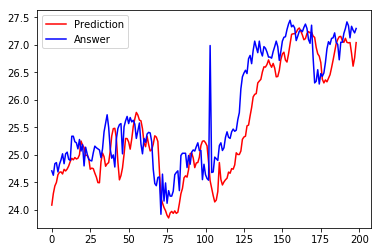

In [47]:
import matplotlib.pyplot as plt
#%matplotlib inline  
plt.plot(denorm_pred,color='red', label='Prediction')
plt.plot(denorm_ytest,color='blue', label='Answer')
plt.legend(loc='best')
plt.show()

In [11]:
score[0]#LOSS 望小

0.0016825175083630798

In [12]:
score[1]#acc 望大

0.002512562814070352